# Introduction to Time Series Analysis

## Introduction

With the advent of big data, an increasing amount of information is being captured by organizations to optimize their operations and enhance their product offerings. Often this data forms a time series - a sequence of data points indexed by time. Forecasting involves predicting future values given past observations of a time series. Common applications of time series forecasting include predicting future sales, patient outcomes, asset prices and resourcing needs.

<p align="center">
<img width="750" alt="Time Series with Missing Values" src="https://user-images.githubusercontent.com/34798787/164544735-ad5d3da7-df84-4fbf-ab1b-dbc2722684e7.jpeg">  
</p>

This two part notebook series provides an overview machine learning for time series forecasting. Throughout the series, we will discuss exploratory analysis, data preprocessing, modelling and evaluation. In doing so, we will encounter several time series forecasting methods from classical statistical approaches ([ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average), [Exponential Smoothing](https://en.wikipedia.org/wiki/Exponential_smoothing), etc.) to state-of-the-art neural network-based methods ([NHITS](https://github.com/cchallu/n-hits), [Temporal Fusion Transformer](https://arxiv.org/pdf/1912.09363.pdf), etc.). To illustrate concepts, we will use Python packages such as [`pandas`](https://pandas.pydata.org/), [`statsmodels`](https://www.statsmodels.org/stable/index.html) and [`darts`](https://unit8co.github.io/darts/). The outline for this notebook - Intro to Time Series is below: 


## Outline

- **Intro to Time Series**

- **Basic Time Series Operations**
    - Missing Values
    - Resampling
    - Denoising

- **Time Series Analysis**
    - Autocorrelation and Partial Autocorrelation 
    - Cross Correlation
    - Time Series Decomposition 
    - Stationairy Data
    - Making Data Stationairy

- **Conclusion** 

- **References**

- **Next Steps**

## Environment Configuration and Imports

**IF USING COLAB: After installing the dependencies into the notebook you must restart the kernel. Simply, go under the Runtime tab and select Restart and Run All. This must be done only after the first time executing the notebook in a given session.** 

In [1]:
import sys
in_colab = 'google.colab' in sys.modules

if in_colab: 
    !pip install darts
    !pip install pyyaml==5.4.1
    !pip install -U matplotlib

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pywt

import numpy as np
import pandas as pd 

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.datasets import GasRateCO2Dataset
from darts.datasets import AirPassengersDataset
from darts.dataprocessing.transformers import MissingValuesFiller

## Intro to Time Series

Time Series data is a sequence of data points indexed by time.  In the simplest case, each datapoint $x_i$ is a scalar in whats referred to as a univariate time series. We can represent a univariate time series with N observations using a value vector $\mathbf{x} \in R^N$ where the index $i \dots N$ represent the time step:  

\begin{align}
\mathbf{x} = \begin{bmatrix} x_{1} \\ \vdots \\ x_{N} \end{bmatrix}
\end{align}

In contrast, a multivariate time series has a vector $X_ i \in R^{M}$ of observations at each time step. In this way, a multivariate time series is a set of time series over the same indices. It follows that multivariate time series are represented as matrices $X \in R^{NxM}$ where the row index $i \dots N$ is the time step and the column index $j \dots M$ is the time series: 

\begin{align}
\mathbf{x} = 
\begin{bmatrix} 
x_{1, 1}  & \cdots & x_{1, M}\\
\vdots & \cdots & \vdots\\ 
x_{N, 1}  & \cdots & x_{N, M}\\     
\end{bmatrix}
\end{align}


### Load Univariate Data


To solidify this notion, we will use the Air Passenger Dataset which is a univariate time series that tracks the amount of commerical airplane passengers $x_i$ by month $i$. We can use the [`darts.datasets.AirPassengersDataset.load`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) function to load the dataset: 

In [3]:
ts = AirPassengersDataset().load()
df = ts.pd_dataframe()
df

component,#Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
...,...
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,461.0


## Generate Missing Value DF

In [4]:
val_list = df["#Passengers"].tolist()
null_index_list = [i for i in range(len(df)) if i % 8 == 0]

In [5]:
mv_df = df.copy()
mv_df["#Passengers"][null_index_list] = np.nan
mv_df

component,#Passengers
Month,
1949-01-01,NaN
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
...,...
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,461.0


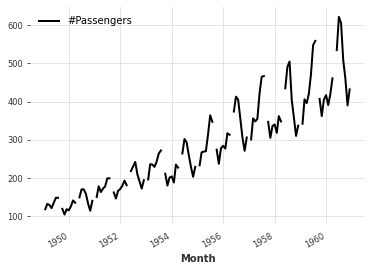

In [6]:
mv_ts = TimeSeries.from_dataframe(mv_df)
mv_ts.plot()

## Time Series Operations



### Missing Values

As evidenced by the above plot, their are missing values at some indexes $i$ in the time series. In general, missing values $x_i$ can be filled with a previous non missing value $x_i$ (forward fill) or a function (average, etc.) of previous non missing values. It is important to note that missing values should always be filled using a function of previous values to avoid introducting a look ahead bias. We can apply the [`pandas.DataFrame.ffill`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ffill.html) method to the underlying `pandas.DataFrame` in order generate the forward filled series: 

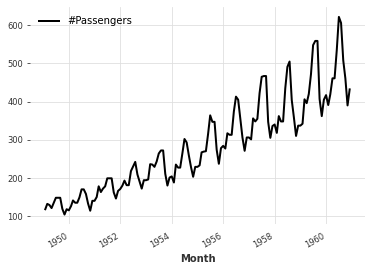

In [7]:
ffill_df = mv_df.ffill()
ts = TimeSeries.from_dataframe(ffill_df)
ts.plot()

## Resampling 

The temporal resolution is the frequency at which the observations in the time series occur. Common temporal resolution include hourly, daily and weekly data. It is generally assumed the temporal resolution of the time series is constant accross observations. We can use resampling to change the temporal cadence of the time series by using upsampling or downsampling.

<p align="center">
<img width="433" alt="Screen Shot 2021-09-28 at 5 41 20 PM" src="https://user-images.githubusercontent.com/34798787/161643733-d811dd99-6ac8-4ce8-b736-74441e13a8b0.png">  
</p>

**Downsampling:** Decreases frequency of observations by reducing the sampling rate of the input time series. This involves omitting intermediate values $x_j$ that lie between points $x_i$ and $x_k$. More formally, the downsampling operation maps the original time series $\mathbf{x} \in R^{N}$ to a lower resolution time series $\mathbf{\hat{x}} \in R^{D}$.

We can downsample the monthly time series to quarterly using the [`darts.TimeSeries.resample`](https://unit8co.github.io/darts/generated_api/darts.timeseries.html#darts.timeseries.TimeSeries.resample) method:

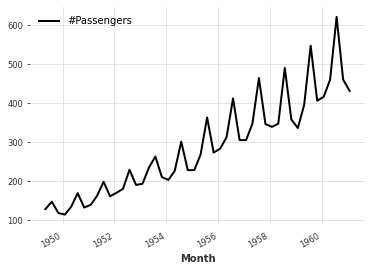

In [8]:
quarterly_series = ts.resample("3M")
quarterly_series.plot()

**Upsampling:** Increases frequency of observations by genarating intermediate values $x_j$ by interpolating/filling between adjacent time series values $x_i$ and $x_k$. More formally, the upsampling operation maps the original time series $\mathbf{x} \in R^{D}$ to a higher resolution time series $\mathbf{\hat{x}} \in R^{N}$.

Similar to downsampling, we can upsample the time series from monthly to weekly data using the [`darts.TimeSeries.resample`](https://unit8co.github.io/darts/generated_api/darts.timeseries.html#darts.timeseries.TimeSeries.resample) method: 

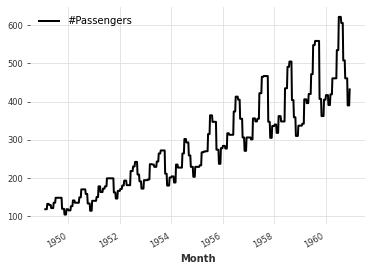

In [9]:
weekly_series = ts.resample("1W")
weekly_series.plot()

In [10]:
ds_df = df.resample("3M").mean()
print(ds_df.columns)
ds_df.index.names = ["Quarter"]

Index(['#Passengers'], dtype='object', name='component')


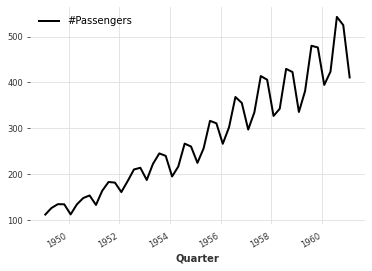

In [11]:
ds_ts = TimeSeries.from_dataframe(ds_df)
ds_ts.plot()

In [12]:
us_df = ds_df.resample("1M").ffill() 
us_df.index.names = ["Day"]

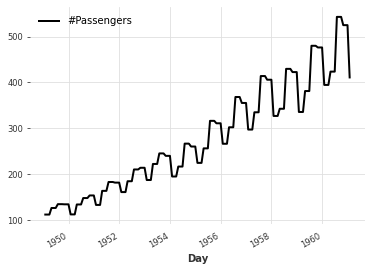

In [13]:
us_ts = TimeSeries.from_dataframe(us_df)
us_ts.plot()

### Denoising


As a stochastic process, time series are vulnerable to noise. It is often helpful to denoise data - a process that involves filtering out noise to extract the underlying signal. There are [many approaches](https://www.kaggle.com/code/residentmario/denoising-algorithms/notebook) to denoising time series data, we will explore just one - Average Smoothing. 

**Average Smoothing:** Average smoothing involves iteratively computing the average over a sliding window of observations that is incremented by a stride accross the entire time series. This computation can be realized using average pooling on input time series with padding to ensure the output time series has the same dimensionality: 

\begin{align}
\hat{x} = AvgPool(Padding(x)) 
\end{align} 

We can write a custom function to perform the operation on a column of the [`pandas.DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) underlying the [`darts.TimeSeries`](https://unit8co.github.io/darts/generated_api/darts.timeseries.html#) object. A new time series can be initialized with the updated dataframe:

In [14]:
def average_smoothing(signal, kernel_size=3, stride=1):
    padding_size = kernel_size // 2
    padded_signal = np.pad(signal, padding_size)
    samples = []
    start = 0 
    while True:
        start = start
        end = start + kernel_size
        val = padded_signal[start:end].mean()
        samples.append(val)
        start += 1
        if end == len(padded_signal):
            break 

    res = np.array(samples)
    return res

<AxesSubplot: xlabel='Month'>

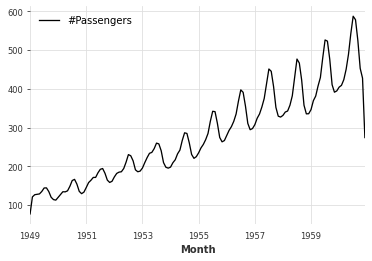

In [15]:
# Get index and time series
np_ts = df["#Passengers"].to_numpy()
index = df.index

# Average Smoothing 
dn_as = average_smoothing(np_ts)
dn_as_df = pd.DataFrame()
dn_as_df.index = index 
dn_as_df["#Passengers"] = dn_as

# Plot new time series
dn_as_ts = TimeSeries.from_dataframe=(dn_as_df)
dn_as_ts.plot()

## Time Series Analysis

### Time Series Decomposition

In time series analysis, it is common to decompose a time series into multiple components representing difference factors of variation. These includes the trend, cyclical, seasonal and residual (irregular) component. 

- **Trend:** General tendency of the time series to increase or decrease over time. 
- **Cyclical:** Fluctuations in the values of the time series occuring at irregular intervals. 
- **Periodic:** Fluctuations in the values of time series occuring at regular intervals. 
- **Residual:** Fluctuations in the values of time series which are a result of unforeseen and unpredictable forces.

The following figure illustrates the various components of a time series:
<p align="center">
<img width="600" alt="Time Series Decomposed" src="https://user-images.githubusercontent.com/34798787/162814965-36e19675-c439-4636-bf40-88dc1e99c416.png"> 
</p> 

It is worth noting that the trend and cyclical components are often lumped together when realizing the decomposition of the underlying time series. With this assumption in place, we can formally specify the interaction of the sub components of the time series. Two simple models for time series deomposition include additive decomposition and multiplicative decomposition. 

**Additive Decomposition:** Assumes additive interaction between sub components of time series. Additive decomposition are most appropriate in the case where the magnitude of the seasonal and/or trend-cyclical fluctuations do not vary with time. The additive decomposition can be formally specified as follows:

\begin{align}
x_{i} = s_{i} + t_{i} + r_{i}
\end{align}

where $x_{i}$ is the time series value, $s_{i}$ is the seasonal componemt, $t_{i}$ is the trend compenent and $r_i$ is the residual component, all at time $i$.

In the case of the Air Passenger time series, the additive decomposition  can be performed with the [`sm.tsa.seasonal_decompose`](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) function with `model="additive"`as follows:

In [16]:
# graphs to show seasonal_decompose
def seasonal_decompose(y, model):
    decomposition = sm.tsa.seasonal_decompose(y, model=model, extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

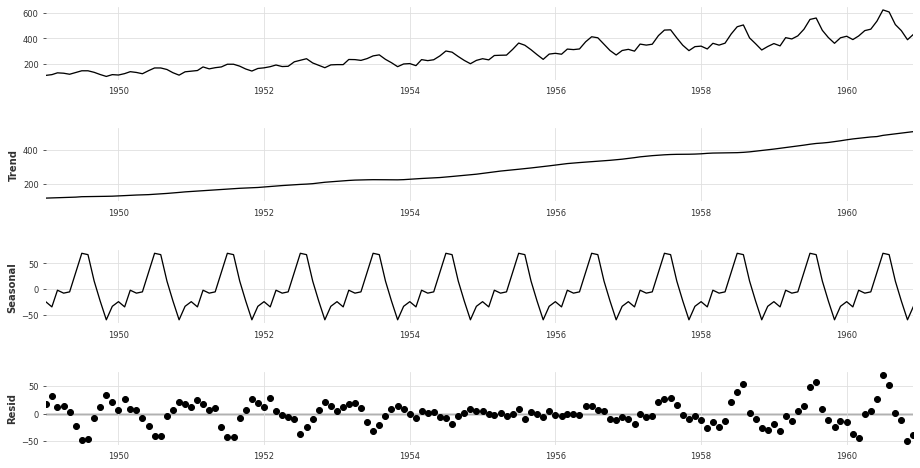

In [17]:
# Decompose Air Passenger additive
seasonal_decompose(df, model="additive")

**Multiplicative Decomposition:** Assumes multiplicative interaction between sub components of the time series. Multiplivative decomposition is most appropriate in the case where the magnitude of the seasonal and/or trend-cyclical fluctuations do not very with time. The multiplicative decomposition can be formally specified as follows: 

\begin{align}
x_{i} = s_{i} \times t_{i} \times r_{i}
\end{align}

where $x_{i}$ is the time series value, $s_{i}$ is the seasonal componemt, $t_{i}$ is the trend compenent and $r_i$ is the residual component, all at time $i$.

In the case of the Air Passenger time series, the multiplicative decomposition  can be performed with the [`sm.tsa.seasonal_decompose`](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) function `model="multiplicative"` as follows:

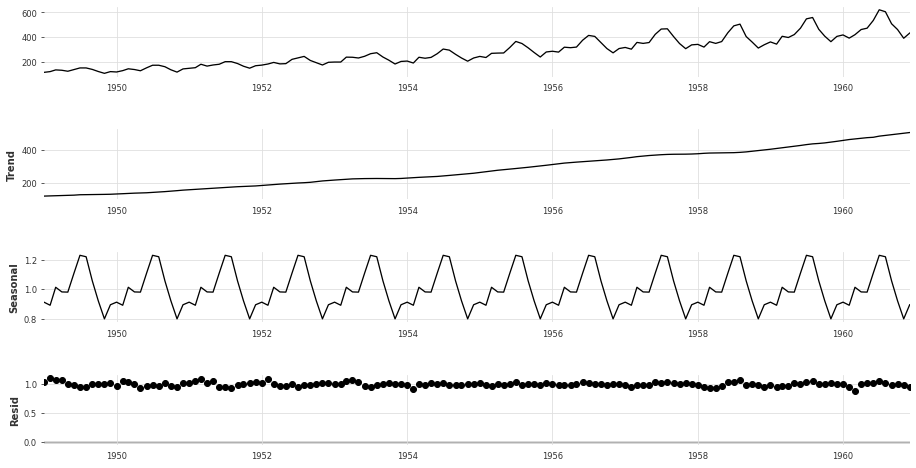

In [18]:
# Decompose Ait Passenger Multiplicative 
seasonal_decompose(df, model="multiplicative")

By looking at the plots of the residuals, it is evident that the multiplicative decomposition is more appropriate for this time series. This is due to the fact that the residuals approximate a normal distribution with mean 0. In the case of the additive decomposition, the residuals seem to have underlying patterns, indicating they are not exclusively noise.

### Autocorrelation and Partial Autocorrelation

One central component in time series analysis is discovering the relative depencies among indices of the time series. To this end, [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation) and [partial autocorrelation](https://en.wikipedia.org/wiki/Partial_autocorrelation_function) are two metrics that measure this. 

**Autocorrelation:** Correlation of a signal with a lagged version of itself as function of the delay. Given a time seres $\mathbf{^{t}x}$ and its $k$ lagged series $\mathbf{^{t-k}x}$, the autocorrelation $a_{k}$  can be calculated as follows: 


\begin{align}
a_{k} = \frac{\mathbb{E}[(\mathbf{^{t}x} - \mu_{x})(\mathbf{^{t-k}x} - \mu_{x})]}{\sqrt{(\mathbb{E}[(\mathbf{^{t}x} - \mu_{x})^2])\cdot \mathbb{E}[(\mathbf{^{t-k}x} - \mu_{x})^2])}} = \
\frac{cov(\mathbf{^{t}x}, \mathbf{^{t-k}x})}{\sqrt{var(\mathbf{^{t}x}) \cdot var(\mathbf{^{t-k}x})}}
\end{align}

where $cov$ is a function that computes covariance and  $var$ is a function that computes the variance. By computing the $A_k$ for all lags from $1$ to $K$, we generate a  vector $A \in R^K$ where each entry represents the autocorrelation for a specific lag. In the case of the Air Passenger Dataset, the autocorrelation with $K=25$ can be plotted using the [`statsmodels.graphics.tsaplots.plot_acf`](https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html) function.

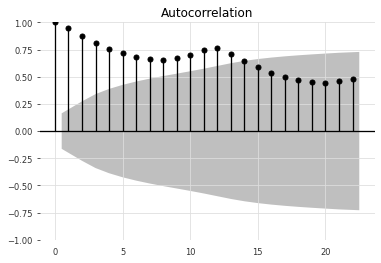

In [19]:
# Autocorrelation 
plot_acf(df['#Passengers'])
print()

The autocorrelation ranges from -1 (tend to move in same direction) and 1 (tend to move in different directions). From the above plot, the lag series $\mathbf{^{t-k}x}$ has the highest autocorrelation, 1, when $k=0$. This makes sense intuitively because $\mathbf{^{t}x}$ and $\mathbf{^{t-k}x}$ are equivalent when $k=0$. You will also notice a shaded area which corresponds to the confidence interval. If an autocorrelation value exceeds the confidence interval region, the autocorrelation value is statistically significant. 

**Partial Autocorrelation:** Correlation of a signal with a lagged version of itself as function of the delay with the relationships of intervening observations removed.  Using partial correlation helps derive the depencies among time steps more accurately by controlling for the effects of other lags. Given a time seres $\mathbf{^{t}x}$ and its $k$ lagged series $\mathbf{^{t-k}x}$, the partial autocorrelation $p_{k}$  can be calculated as follows: 

\begin{align}
p_{k} = 
\frac{cov(\mathbf{^{t}x}, \mathbf{^{t-k}x}| \mathbf{^{t-1}x}, \cdots, \mathbf{^{t-k+1}x})}{\sqrt{var(\mathbf{^{t}x} | \mathbf{^{t-1}x}, \cdots, \mathbf{^{t-k+1}x}) \cdot var(\mathbf{^{t-k}x} | \mathbf{^{t-1}x}, \cdots, \mathbf{^{t-k+1}x})}}
\end{align}

where $cov$ is a function that computes covariance between $\mathbf{^{t}x}$ and $\mathbf{^{t-k}x}$ conditioned on intermediate values and $var$ is a function that computes the variance of $\mathbf{^{t}x}$ and $\mathbf{^{t}x}$ conditioned on intermediate values. By computing the  $p_k$  for all lags from  1  to  𝐾 , we generate a vector  $\mathbf{p}  \in 𝑅^𝐾$  where each entry represents the autocorrelation for a specific lag. In the case of the Air Passenger Dataset, the partial autocorrelation with  𝐾=25  can be plotted using the [`statsmodels.graphics.tsaplots.plot_pacf`](https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_pacf.html) function:


/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


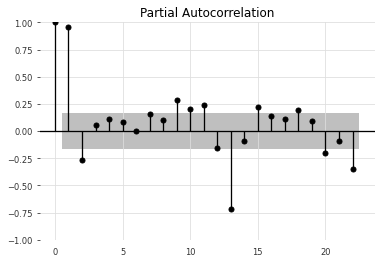

In [20]:
# Partial Autocorrelation 
plot_pacf(df['#Passengers'])
print()

The partial autocorrelation ranges from -1 (tend to move in same direction) and 1 (tend to move in different directions). In contrast to the autocorrelation plot, the partial autocorrelation plot highlights dependicies based solely on their contribution. You will also notice a shaded area which corresponds to the confidence interval. If an partial autocorrelation value exceeds the confidence interval region, the partial autocorrelation value is statistically significant. 

### Cross Correlation

Often it is beneficial to compare multiple time series to discover what relationships exist. By generalizing the notion of autocorrelation, we are able to define [cross correlation](https://en.wikipedia.org/wiki/Cross-correlation) which describes the relationship between a pair of time series at different lags. To account for the fact that we can compute lags on each time series independently, we have defined positive and negative lags to evaulate the correlation of the two time series. A positive lag in one time series is a negative lag in the other time series and vice versa. 

To illustate the concept of cross correlation, we can compute an affine transformation on the AirPassenger time series and compute the cross correlation between the two time series at different lags with a maximum lag of $ K = \pm 10 $. The function [`matplotlib.pyplot.xcorr`](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.xcorr.html) is useful for generating a cross correlation plot for a pair of time series: 

[]

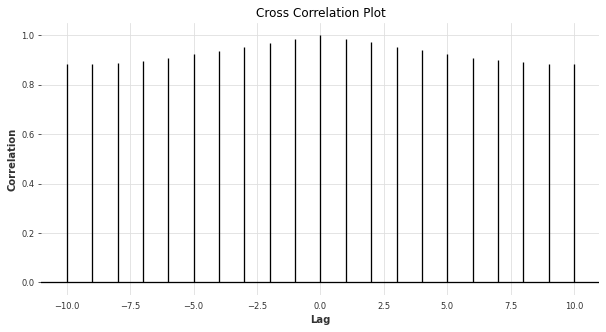

In [21]:
passengers = df["#Passengers"]
passengers_shifted = passengers + 10

f, axarr = plt.subplots(1, 1, figsize=(10, 5))
axarr.xcorr(passengers, passengers_shifted, maxlags=10, normed=True)
axarr.set_title("Cross Correlation Plot")
axarr.set_xlabel("Lag")
axarr.set_ylabel("Correlation")
axarr.plot()

### Stationairity

Many techniques for time series forecasting assume that the underlying time series is stationairy. A stationairy time series has constant mean and variance over time. In many cases, time series are not stationairy. As a quick check, we can determine if a given time series is stationariy by visualizing the mean and variance as a function of time.

In the case of the Air Passenger time series, the visualization can be generated as follows:

In [22]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

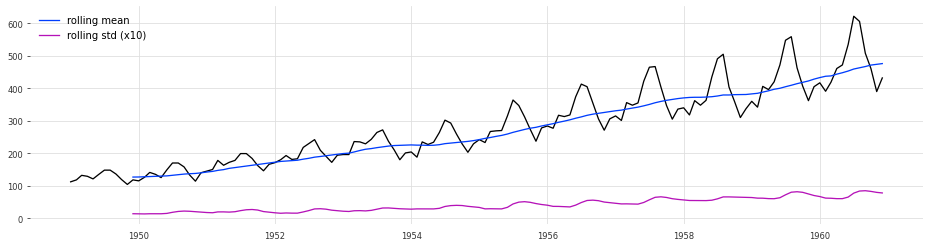

In [23]:
test_stationarity(df["#Passengers"], "")

Clearly, the time series is not stationairy because both the standard deviation and the mean change accross time. In some cases, it may not be apparent from such a visualiztion so we can resort to statistical tests to determine whether or not the time series is stationairy. On such statistical test is the [Augmented Dickey-Fuller Test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) which can be implented using the [`statsmodels.tsa.stattools.adfuller`](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html) function as follows: 

In [24]:
# Augmented Dickey-Fuller Test

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [25]:
ADF_test(df["#Passengers"], "Air Passenger Time Series")

 > Is the Air Passenger Time Series stationary ?
Test statistic = 0.815
P-value = 0.992
Critical values :
	1%: -3.4816817173418295 - The data is not stationary with 99% confidence
	5%: -2.8840418343195267 - The data is not stationary with 95% confidence
	10%: -2.578770059171598 - The data is not stationary with 90% confidence


### Making Data Stationairy

Their are several methods to make time series data stationairy. This is required in cases that you are employing a time series analysis method that assumes their is constant mean and covariance accross the entire time series. The time series methods explored in this section are [detrending](https://machinelearningmastery.com/time-series-trends-in-python/) and [differencing](https://machinelearningmastery.com/time-series-trends-in-python/). 

**Detrending:** Involves subtracting out the underlying trend in the time series to generate the detrended series. The trend can be determined using a average smoothing or other methods. In the case of the Air Pasender Dataset, we can process the time series by detrending it. Subsequently, we can evaluate whether the detrended time series is stationairy:

 > Is the de-trended data stationary ?
Test statistic = -2.481
P-value = 0.120
Critical values :
	1%: -3.4865346059036564 - The data is not stationary with 99% confidence
	5%: -2.8861509858476264 - The data is not stationary with 95% confidence
	10%: -2.579896092790057 - The data is not stationary with 90% confidence


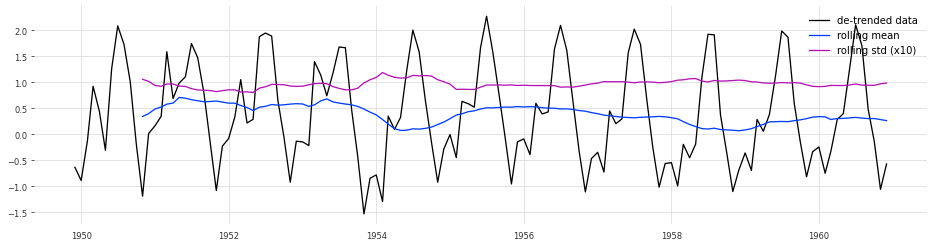

In [26]:
# Detrending
y = df["#Passengers"]
y_detrend =  (y - y.rolling(window=12).mean())/y.rolling(window=12).std()

test_stationarity(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

Although, the ADF test does not currently consider the time series to be stationairy, it is a significant improvement over the otiginal time series. 

**Differencing:** Removes underlying cyclical and seasonal patterns by substracting out a lagged value of the series.  In the case of the Air Pasender Dataset, we can process the time series by differencing it. Subsequently, we can evaluate whether the differenced time series is stationairy:

 > Is the 12 lag differenced data stationary ?
Test statistic = -3.383
P-value = 0.012
Critical values :
	1%: -3.4816817173418295 - The data is not stationary with 99% confidence
	5%: -2.8840418343195267 - The data is  stationary with 95% confidence
	10%: -2.578770059171598 - The data is  stationary with 90% confidence


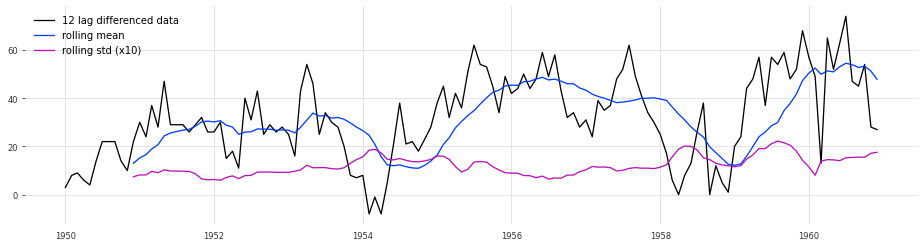

In [27]:
# Differencing 
y_12lag =  y - y.shift(12)
test_stationarity(y_12lag,'12 lag differenced data')
ADF_test(y_12lag,'12 lag differenced data')

By using differencing, the processed time series is considered stationairy. Although for the highest confidence interval, it is not deemed stationairy. To mitigate this we can explore other methods for making the data stationairy or combining differencing and detrending to hopefully yield more robust results. 

 > Is the 12 lag differenced de-trended data stationary ?
Test statistic = -3.181
P-value = 0.021
Critical values :
	1%: -3.4924012594942333 - The data is not stationary with 99% confidence
	5%: -2.8886968193364835 - The data is  stationary with 95% confidence
	10%: -2.5812552709190673 - The data is  stationary with 90% confidence


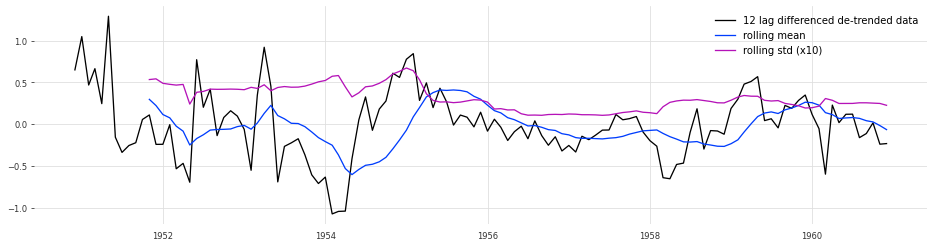

In [28]:
# Detrending and Differencing 
y_12lag_detrend =  y_detrend - y_detrend.shift(12)
test_stationarity(y_12lag_detrend,'12 lag differenced de-trended data')
ADF_test(y_12lag_detrend,'12 lag differenced de-trended data')

## Conclusion 

In this notebook univariate time series analysis is explored. Topics we covered include: 
- Basic Time Series operations such as imputing missing values, resampling and denoising.
- Discovering dependencies between steps of a time series with autocorrelation and partial autocorrelation.
- Discovering dependencies between steps of a pair of time series with cross-correlation. 
- Decomposing a time series into trend, seasonal, cyclical and residual components
- Determining if a series is stationary and methods for making data stationairy.

## Resources
- [Forecasting with a Time Series Model using Python: Part One](https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-one/)
- [A Comprehensive Guide to Time Series Analysis](https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-to-time-series-analysis/)
- [Time series analysis in Python](https://www.kaggle.com/code/kashnitsky/topic-9-part-1-time-series-analysis-in-python/notebook#Conclusion)

## Next Steps
- Apply techniques for time series analysis to dataset for use case (or similar open source dataset) 
- Dive deeper into the topics we explored in the following notebook: [TS-0: The Basics](https://www.kaggle.com/code/konradb/ts-0-the-basics/notebook) 